In [1]:
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import numpy as np

mnist = fetch_openml('mnist_784',as_frame=False) # Load MNIST dataset from OpenMl

In [2]:
X, y = mnist.data, mnist.target # Get inputs in X and labels in y
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (70000, 784)
y shape: (70000,)


'5'

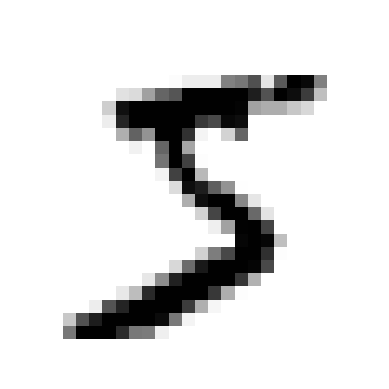

In [3]:
# Function to plot an image from an array 784x1 representing the pixel intensity [0,255] of a 28x28 image. 
# If output = True, then the resized vector is returned
def plot_img(img,output=None):
    img = img.reshape(28,28)
    plt.imshow(img,cmap='binary')
    plt.axis('off')
    return img if output  else None
plot_img(X[0,:])
y[0]

In [4]:
# The mnist data set returned by fetch_openml is already divided in training (first 60000 entries) and test (last 10000 entries)
# The training set is already shuffled
X_train, X_test, y_train, y_test = X[:60000,:],X[-10000:,:],y[:60000],y[-10000:]

## First approach

Attempting a binnary classifier to classify as 5 or non-5

In [5]:
y_train_5 = (y_train == '5') # '5' labels are converted to True, and all others to False
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=0)
sgd_classifier.fit(X_train,y_train_5)

SGDClassifier(random_state=0)

In [7]:
sgd_classifier.predict([X[0,:]])

array([False])

## Evaluate performance

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier,X_train,y_train_5,scoring='accuracy',cv=3)

array([0.9499, 0.9556, 0.966 ])

## Testing most frequent classification

In [9]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent',random_state=42)
dummy_clf.fit(X_train,y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [10]:
cross_val_score(dummy_clf,X_train,y_train_5,scoring='accuracy',cv=3)

array([0.90965, 0.90965, 0.90965])

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier,X_train,y_train_5,cv=3)

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[52931,  1648],
       [  922,  4499]], dtype=int64)

In [13]:
from sklearn.metrics import precision_score, recall_score

print(f'Precision: {precision_score(y_train_5,y_train_pred)}')
print(f'Recall: {recall_score(y_train_5,y_train_pred)}')

Precision: 0.7319017406865137
Recall: 0.8299206788415422


In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.77783540802213

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_classifier,X_train,y_train_5,cv=3,method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

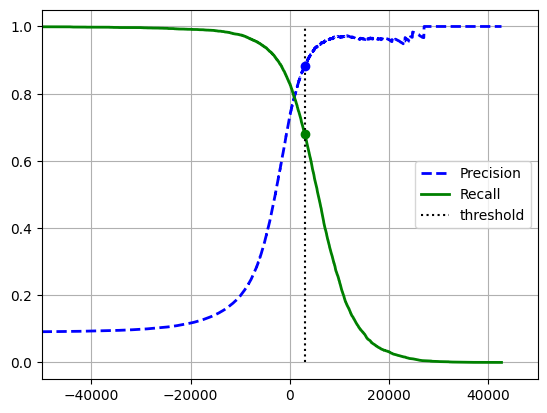

In [16]:
plt.plot(thresholds,precisions[:-1],'b--',label='Precision',linewidth=2)
plt.plot(thresholds,recalls[:-1],'g-',label='Recall',linewidth=2)
plt.vlines(3000,0,1.0,'k','dotted',label='threshold')
for idx in range(len(precisions)-1):
    if thresholds[idx] > 2999.5 and thresholds[idx] < 3000.5:
        break
plt.plot(thresholds[idx],precisions[idx],'bo')
plt.plot(thresholds[idx],recalls[idx],'go')
plt.grid(True)
plt.axis(xmin=-50000,xmax=50000)
plt.legend()
plt.show()

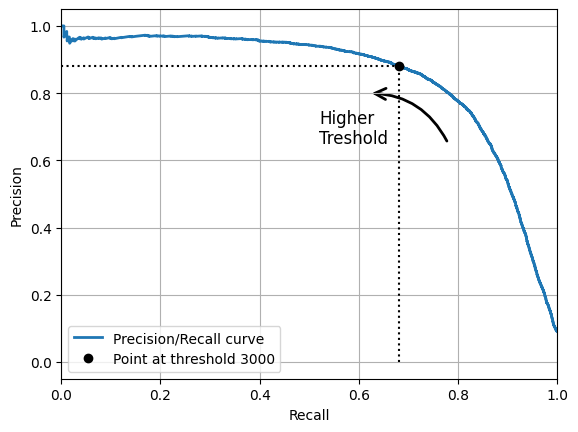

In [17]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path

fig,ax = plt.subplots()
ax.plot(recalls,precisions,linewidth=2,label='Precision/Recall curve')
ax.plot(recalls[idx],precisions[idx],'ko',label='Point at threshold 3000')
arrow = FancyArrowPatch(
    (0.78,0.65), (0.62,0.8), 
    connectionstyle="arc3,rad=0.3",  # Controla la curvatura
    arrowstyle="->", 
    linewidth=2, 
    mutation_scale=20,
    color="black"
)
ax.add_patch(arrow)
ax.vlines(recalls[idx],0,precisions[idx],'k','dotted')
ax.hlines(precisions[idx],0,recalls[idx],'k','dotted')
ax.text(0.52, 0.65 , "Higher\nTreshold", fontsize=12, color="black")
plt.xlabel("Recall")
plt.ylabel("Precision")
ax.grid(True)
ax.axis(xmin=0,xmax=1)
ax.legend()
plt.show()

In [18]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3611.731693631048

In [19]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [20]:
precision_score(y_train_5,y_train_pred_90)

0.9000776598498577

In [21]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.6413945766463752

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

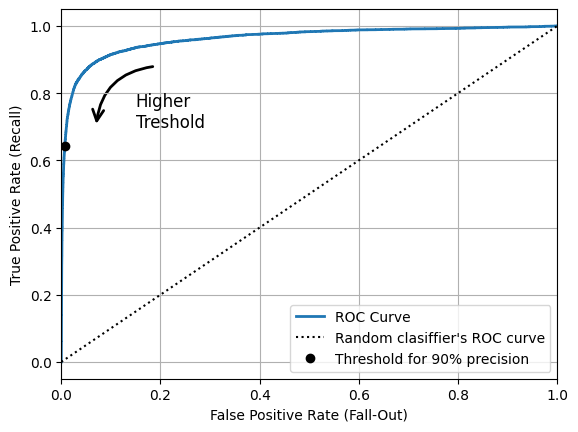

In [23]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90],fpr[idx_for_threshold_at_90]

fig,ax = plt.subplots()
ax.plot(fpr,tpr,linewidth=2,label='ROC Curve')
ax.plot([0,1],[0,1],'k:',label="Random clasiffier's ROC curve")
ax.plot([fpr_90],[tpr_90],'ko',label='Threshold for 90% precision')
arrow = FancyArrowPatch(
    (0.19,0.88), (0.07,0.7), 
    connectionstyle="arc3,rad=0.4",  # Controla la curvatura
    arrowstyle="->", 
    linewidth=2, 
    mutation_scale=20,
    color="black"
)
ax.add_patch(arrow)
ax.text(0.15, 0.7 , "Higher\nTreshold", fontsize=12, color="black")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
ax.grid(True)
ax.axis(xmin=0,xmax=1)
ax.legend()
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9624892334207759

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
y_probas_rf = cross_val_predict(rf_classifier,X_train,y_train_5,cv=3,method='predict_proba')

In [26]:
y_probas_rf[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [27]:
y_scores_forest = y_probas_rf[:,1]
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train_5,y_scores_forest)

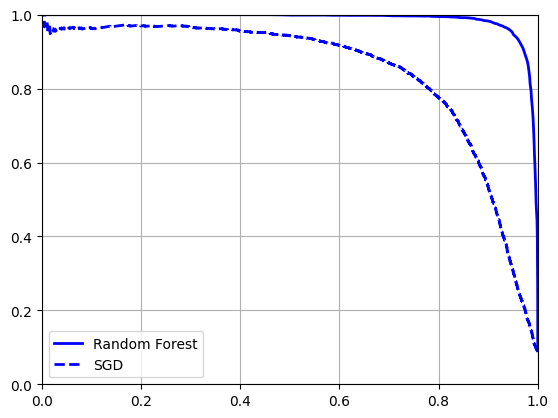

In [28]:
fig,ax = plt.subplots()
ax.plot(recalls_rf,precisions_rf,'b-',linewidth=2,label='Random Forest')
ax.plot(recalls,precisions,'b--',linewidth=2,label='SGD')
ax.axis(xmin=0.0,xmax=1.0,ymin=0.0,ymax=1.0)
ax.legend()
ax.grid(True)

In [29]:
y_train_pred_forest = y_probas_rf[:,1] >= 0.5
print(f'f1: {f1_score(y_train_5,y_train_pred_forest)}')
print(f'roc_auc: {roc_auc_score(y_train_5,y_train_pred_forest)}')

f1: 0.9274509803921569
roc_auc: 0.9358174809192218


In [30]:
precision_score(y_train_5,y_train_pred_forest)

0.9897468089558485

In [31]:
recall_score(y_train_5,y_train_pred_forest)

0.8725327430363402

## Multiclass classification

- One vs All: less classifiers to train
- One vs One: classifiers trained on fewer examples, prefered for SVC or other algorithms that scale poorly with training size

In [32]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])

SVC(random_state=42)

In [33]:
svm_clf.predict([X_train[0,:]])

array(['5'], dtype=object)

In [34]:
some_digit_scores = svm_clf.decision_function([X_train[0,:]])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)
X_train_scaled = StandardScaler().fit_transform(X_train.astype("float64"))
y_train_pred = cross_val_predict(sgd_classifier,X_train_scaled,y_train,cv=3)

C:\Users\Mauri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


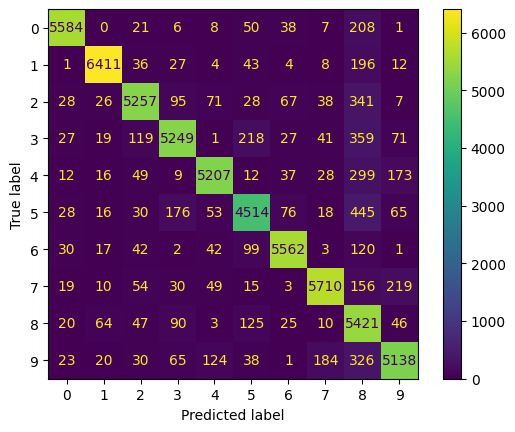

In [36]:
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
plt.show()

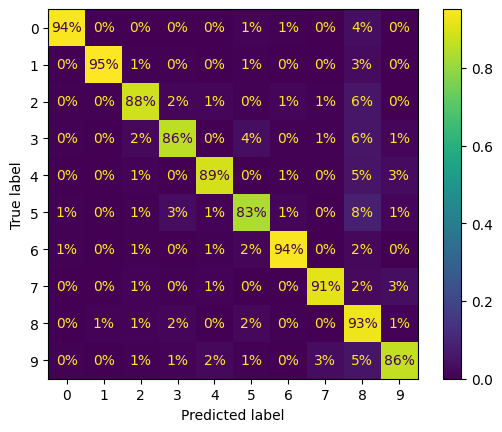

In [37]:
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",values_format=".0%")
plt.show()

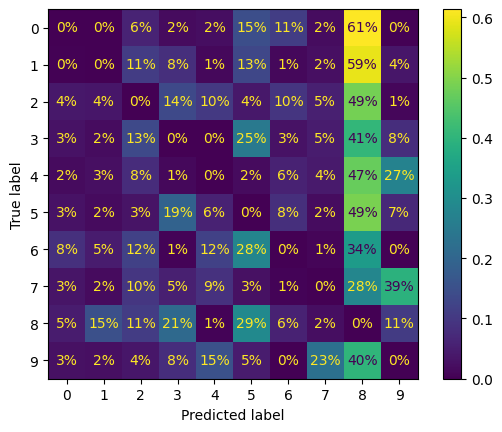

In [38]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",values_format=".0%",sample_weight=sample_weight)
plt.show()

In [39]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred==cl_b)]

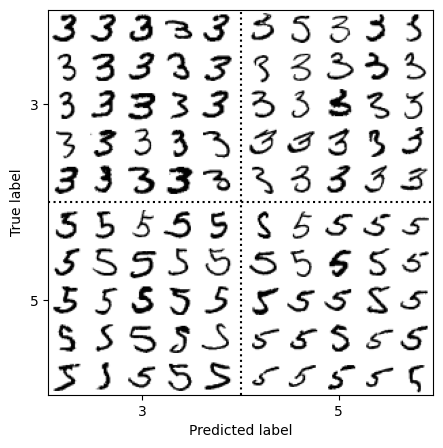

In [40]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Multilabel Classification

In [41]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [42]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [43]:
knn_clf.predict([X_train[0,:]])

array([[False,  True]])

In [44]:
# Computing F1
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.9764102655606048

In [45]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [46]:
chain_clf.predict([X_train[0,:]])

array([[0., 1.]])

## Multioutput Classification

In [47]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train),784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

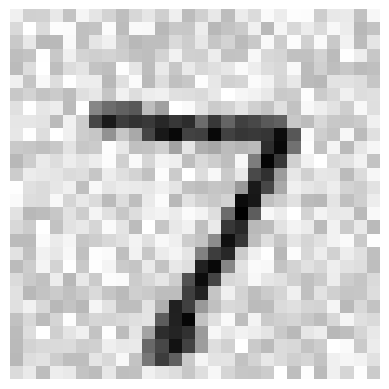

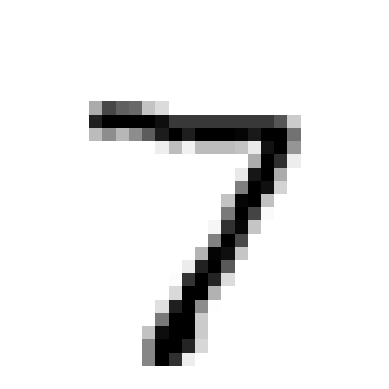

In [48]:
plt.subplots()
plot_img(X_test_mod[0,:])
plt.show()
plot_img(X_test[0,:])

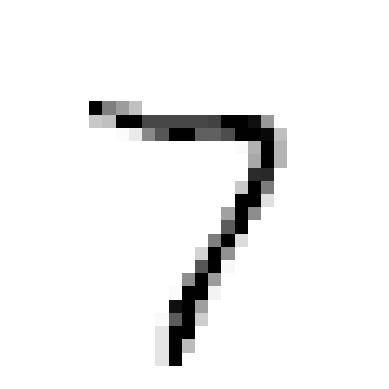

In [49]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0,:]])
plot_img(clean_digit)

## Excercises

MNIST 97% accuracy on test

In [144]:
from sklearn.model_selection import GridSearchCV
param_grid = {'weights': ['uniform','distance'],'n_neighbors': [2,3,4,5,6,7]}
knn_gs = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,scoring='accuracy',cv=3)
knn_gs.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [145]:
knn_gs_pred = knn_gs.predict(X_test)

In [146]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,knn_gs_pred) # 97% achieved

0.9714

Data augmentation

<class 'numpy.ndarray'>


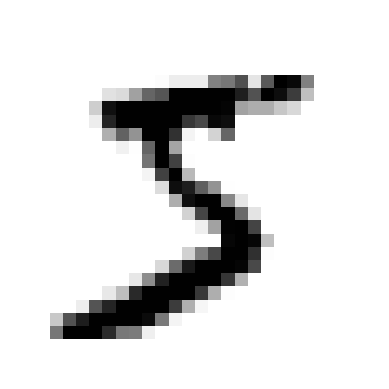

<class 'numpy.ndarray'>


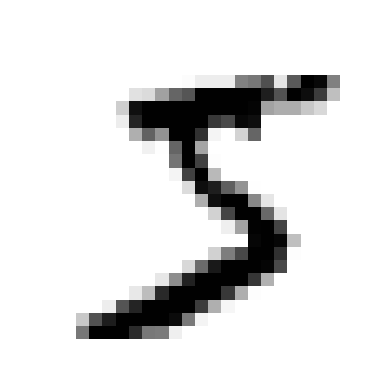

<class 'numpy.ndarray'>


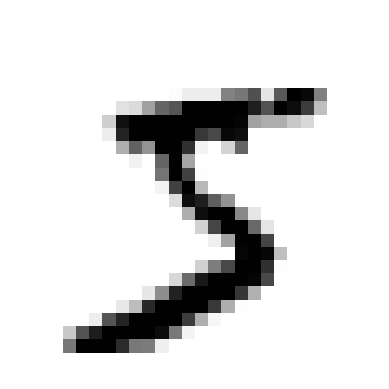

<class 'numpy.ndarray'>


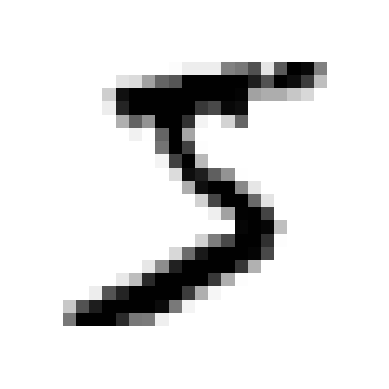

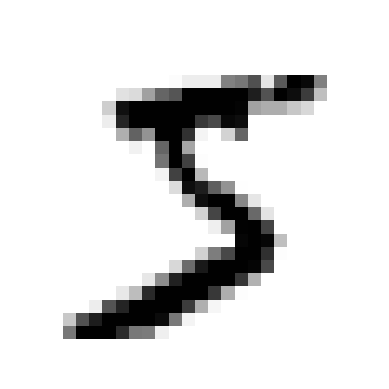

In [147]:
from scipy.ndimage import shift

def shift_img(img):
    img_mat = img.reshape((28,28))
    
    # shift left
    img_left =  shift(img_mat, [0, -1], cval=0, mode="constant")

    #shift right
    img_right = shift(img_mat, [0, 1], cval=0, mode="constant")

    #shift up
    img_up = shift(img_mat, [1, 0], cval=0, mode="constant")

    #shift down
    img_down = shift(img_mat, [-1, 0], cval=0, mode="constant")
    return (img_left.reshape((1,784)),img_right.reshape((1,784)),img_up.reshape((1,784)),img_down.reshape((1,784)))
    
plt.subplots()
for img in shift_img(X_train[0,:]):
    print(type(img))
    plot_img(img)
    plt.show()
plot_img(X_train[0,:])

In [148]:
from tqdm import tqdm

X_train_augmented = [img for img in X_train]
y_train_augmented = [img for img in y_train]

for idx in tqdm(range(len(X_train))):
    left,right,up,down = shift_img(X_train[idx,:])
    for img in shift_img(X_train[idx,:]):
        X_train_augmented.extend(img)
        y_train_augmented.append(y_train[idx])

100%|██████████████████████████████████| 60000/60000 [00:44<00:00, 1346.72it/s]


In [149]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [150]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [153]:
knn_best = knn_gs.best_estimator_ #KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_best.fit(X_train_augmented,y_train_augmented)
knn_best_pred = knn_gs.predict(X_test)
accuracy_score(y_test,knn_best_pred)

0.9763

Titanic survived prediction available at https://www.kaggle.com/code/mauriciocasarotto/ag-honl-ch3-ex3